<br>  

## <span style='color:blue'>Section 1: Import</span>  

In [1]:
import pandas as pd
import numpy as np
import copy

from sklearn.model_selection import StratifiedKFold

from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

import statsmodels.api as sm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

<br>  

## <span style='color:blue'>Section 2: Read, drop columns, form X_train and y_train</span>  

In [2]:
# ---------- read ----------

df_1 = pd.read_csv('../data/code_3_train.csv')

# ---------- drop ----------

print('Before drop :', df_1.shape)
df_1.drop(columns=['index',
                   'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi',
                   'creatine_kinase', 'lymphocyte', 'neutrophils'], inplace=True)
print('After drop:', df_1.shape)
print('')

# ---------- form X ----------

X_train = df_1.drop(columns=['outcome'])
print('X_train :', X_train.shape)

# ---------- form y ----------

y_train = df_1['outcome']
print('y_train :', y_train.shape)
print('')
print('y_train :', np.unique(y_train, return_counts=True))
print('y_train :', Counter(y_train))
print(y_train.value_counts(normalize=True))

Before drop : (882, 51)
After drop: (882, 42)

X_train : (882, 41)
y_train : (882,)

y_train : (array([0., 1.]), array([763, 119], dtype=int64))
y_train : Counter({0.0: 763, 1.0: 119})
0.0    0.865079
1.0    0.134921
Name: outcome, dtype: float64


<br>  

## <span style='color:blue'>Section 3: Function - Impute</span>  

In [3]:
# ---------- this function is to retain the column names of dataframe after missing values imputation ----------

def impute_fit_transform(to_impute, to_impute_fit_transform):
    temp_df = []
    temp_df = to_impute_fit_transform.fit_transform(to_impute)
    temp_df = pd.DataFrame(temp_df, columns=to_impute.columns)
    to_impute = copy.deepcopy(temp_df)
    return to_impute, to_impute_fit_transform

def impute_transform(to_impute, to_impute_fit_transform):
    temp_df = []
    temp_df = to_impute_fit_transform.transform(to_impute)
    temp_df = pd.DataFrame(temp_df, columns=to_impute.columns)
    to_impute = copy.deepcopy(temp_df)
    return to_impute

<br>  

## <span style='color:blue'>Section 4: Function - Scale</span>  

In [4]:
# ---------- this function is to retain the column names of dataframe after scaling ----------

def scale_fit_transform(to_scale, to_scale_fit_transform):
    temp_df = []
    temp_df = to_scale_fit_transform.fit_transform(to_scale)
    temp_df = pd.DataFrame(temp_df, columns=to_scale.columns)
    to_scale = copy.deepcopy(temp_df)
    return to_scale, to_scale_fit_transform

def scale_transform(to_scale, to_scale_fit_transform):
    temp_df = []
    temp_df = to_scale_fit_transform.transform(to_scale)
    temp_df = pd.DataFrame(temp_df, columns=to_scale.columns)
    to_scale = copy.deepcopy(temp_df)
    return to_scale

<br>  

## <span style='color:blue'>Section 5: Impute, oversample, scale, instantiate, fit, predict - Full train set</span>  

### <span style='color:green'>Best parameters and hyperparameters that result in smallest overfit and performance in recall and precision:</span>  
* <span style='color:green'>Oversample=0.85</span>  
* <span style='color:green'>Decision boundary=0.35</span>  
* <span style='color:green'>Regularisation strength alpha=50</span>  

In [5]:
# ---------- best parameters and hyperparameters ----------

search_parameters = {'oversample': [0.85],
                     'decision_boundary': [0.35]}
alpha_log_reg = 50

print('Before y_train:', Counter(y_train))
print('Oversample :', search_parameters['oversample'][0])
print('Decision boundary :', search_parameters['decision_boundary'][0])
print('alpha =', alpha_log_reg)
print('')

# ---------- impute on train ----------

knn_impute = KNNImputer(n_neighbors=5)
X_train_impute, knn_impute_fit_transform = impute_fit_transform(X_train,
                                                                knn_impute)

# ---------- oversample SMOTE ----------
                                                         
o_s = SMOTE(random_state=42,
            sampling_strategy=search_parameters['oversample'][0])
X_train_impute_over, y_train_over = o_s.fit_resample(X_train_impute,
                                                     y_train.ravel())

print('Before_Over y_train:', Counter(y_train_over))
print('')

# ---------- scale on train ----------

ss = StandardScaler()
X_train_impute_over_scale, ss_fit_transform = scale_fit_transform(X_train_impute_over,
                                                                  ss)

# ---------- instantiate and fit regularized on train ----------

X_train_impute_over_scale = sm.add_constant(X_train_impute_over_scale)
lr = sm.Logit(y_train_over, X_train_impute_over_scale)
lr_result = lr.fit_regularized(maxiter=500, method='l1', alpha=alpha_log_reg)

# ---------- impute, scale and predict on train ----------

X_train_impute = impute_transform(X_train, knn_impute_fit_transform)
X_train_impute_scale = scale_transform(X_train_impute, ss_fit_transform)

X_train_impute_scale = sm.add_constant(X_train_impute_scale)
y_train_predicted = (lr_result.predict(X_train_impute_scale)>=search_parameters['decision_boundary'][0]).astype(int)

Before y_train: Counter({0.0: 763, 1.0: 119})
Oversample : 0.85
Decision boundary : 0.35
alpha = 50

Before_Over y_train: Counter({0.0: 763, 1.0: 648})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5877341576205927
            Iterations: 42
            Function evaluations: 43
            Gradient evaluations: 42


<br>  

## <span style='color:blue'>Section 6: Model summary</span>  

In [6]:
# ---------- model summary ----------

print('-------------------- Model Summary 1: From Statsmodels API --------------------')
print('')
print(lr_result.summary())
print('')

print('-------------------- Model Summary 2: Sorted by ascending p --------------------')
print('')
temp_df = pd.read_html(lr_result.summary().tables[1].as_html(), header=0, index_col=0)[0]
temp_df = pd.DataFrame(temp_df)
temp_df.reset_index(level=0, inplace=True)
temp_df.rename(columns={'index': 'feature', 'std err': 'std_err', 'P>|z|': 'p', 'coef': 'std_coef'}, inplace=True)
temp_df = temp_df[['feature', 'std_coef', 'z', 'p']]
temp_df.sort_values(by='p', ascending=True, inplace=True)
print(temp_df)
print('')

print('-------------------- Model Summary 3: p < 0.05 sorted by coef --------------------')
print('')
print(temp_df[temp_df['p']<0.05][['feature', 'std_coef', 'z', 'p']].sort_values(by='std_coef'))

-------------------- Model Summary 1: From Statsmodels API --------------------

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 1411
Model:                          Logit   Df Residuals:                     1392
Method:                           MLE   Df Model:                           18
Date:                Sun, 02 Jan 2022   Pseudo R-squ.:                  0.2932
Time:                        10:02:56   Log-Likelihood:                -687.96
converged:                       True   LL-Null:                       -973.34
Covariance Type:            nonrobust   LLR p-value:                1.293e-109
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0224      0.060     -0.375      0.707      -0.139       0.095
group   

### <span style='color:green'>Statistically significant features to interpret model:</span>  
* <span style='color:green'>renal_failure</span>  
* <span style='color:green'>bicarbonate</span>  
* <span style='color:green'>blood_calcium</span>  
* <span style='color:green'>urine_output</span>  
* <span style='color:green'>deficiencyanemias</span>  
* <span style='color:green'>sp_o2</span>  
* <span style='color:green'>heart_rate</span>  
* <span style='color:green'>leucocyte</span>  
* <span style='color:green'>atrialfibrillation</span>  
* <span style='color:green'>urea_nitrogen</span>  
<br>  
<br>  


<br>  

## <span style='color:blue'>Section 7: Read, drop columns, form X_test and y_test</span>  

In [7]:
# ---------- read ----------

df_2 = pd.read_csv('../data/code_3_test.csv')

# ---------- drop ----------

print('Before drop :', df_2.shape)
df_2.drop(columns=['index',
                   'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi',
                   'creatine_kinase', 'lymphocyte', 'neutrophils'], inplace=True)
print('After drop:', df_2.shape)
print('')

# ---------- form X ----------

X_test = df_2.drop(columns=['outcome'])
print('X_test :', X_test.shape)

# ---------- form y ----------

y_test = df_2['outcome']
print('y_test :', y_test.shape)
print('')
print('y_test :', np.unique(y_test, return_counts=True))
print('y_test :', Counter(y_test))
print(y_test.value_counts(normalize=True))

Before drop : (294, 51)
After drop: (294, 42)

X_test : (294, 41)
y_test : (294,)

y_test : (array([0., 1.]), array([254,  40], dtype=int64))
y_test : Counter({0.0: 254, 1.0: 40})
0.0    0.863946
1.0    0.136054
Name: outcome, dtype: float64


<br>  

## <span style='color:blue'>Section 8: Impute, scale, predict - Full test set</span>   

In [8]:
# ---------- impute on full test with transform ----------

X_test_impute = impute_transform(X_test, knn_impute_fit_transform)

# ---------- scale on full test with transform ----------

X_test_impute_scale = scale_transform(X_test_impute, ss_fit_transform)

# ---------- predict and evaluate on full test ----------

X_test_impute_scale = sm.add_constant(X_test_impute_scale)
y_test_predicted = (lr_result.predict(X_test_impute_scale)>=search_parameters['decision_boundary'][0]).astype(int)

<br>  

## <span style='color:blue'>Section 9: Evaluate</span>   

In [9]:
# ---------- accuracy, recall, precision, overfit evaluation ----------

print('Train accuracy :', accuracy_score(y_train, y_train_predicted))
print('Test accuracy :', accuracy_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (accuracy_score(y_test, y_test_predicted)-accuracy_score(y_train, y_train_predicted))/accuracy_score(y_train, y_train_predicted)*100)
print('')

print('Train recall :', recall_score(y_train, y_train_predicted))
print('Test recall :', recall_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (recall_score(y_test, y_test_predicted)-recall_score(y_train, y_train_predicted))/recall_score(y_train, y_train_predicted)*100)
print('')

print('Train precision :', precision_score(y_train, y_train_predicted))
print('Test precision :', precision_score(y_test, y_test_predicted))
print('Overfit % = ( Test - Train ) / Train % :',
      (precision_score(y_test, y_test_predicted)-precision_score(y_train, y_train_predicted))/precision_score(y_train, y_train_predicted)*100)
print('')

Train accuracy : 0.564625850340136
Test accuracy : 0.5680272108843537
Overfit % = ( Test - Train ) / Train % : 0.6024096385542176

Train recall : 0.9159663865546218
Test recall : 0.8
Overfit % = ( Test - Train ) / Train % : -12.660550458715589

Train precision : 0.22567287784679088
Test precision : 0.2119205298013245
Overfit % = ( Test - Train ) / Train % : -6.093930372440607



In [10]:
# ---------- confusion matrix calculation ----------

tn, fp, fn, tp = confusion_matrix(y_test, y_test_predicted).ravel()
print('True positive (dead): ', tp)
print('True negative (alive): ', tn)
print('False positive (dead): ', fp)
print('False negative (alive): ', fn)
print('')

print('Accuracy :', accuracy_score(y_test, y_test_predicted))
print('')

print('Sensitivity or Recall :', recall_score(y_test, y_test_predicted))
print('')

print('Precision or Positive Predictive Value :', precision_score(y_test, y_test_predicted))
print('')

print('Specificity :', tn/(tn+fp))
print('')

print('Negative predictive value :', tn/(tn+fn))

True positive (dead):  32
True negative (alive):  135
False positive (dead):  119
False negative (alive):  8

Accuracy : 0.5680272108843537

Sensitivity or Recall : 0.8

Precision or Positive Predictive Value : 0.2119205298013245

Specificity : 0.531496062992126

Negative predictive value : 0.9440559440559441


Text(69.0, 0.5, 'predicted')

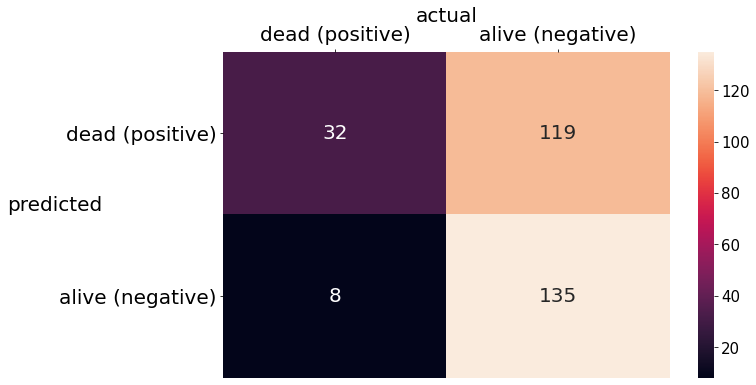

In [11]:
# ---------- confusion matrix visualisation ----------

temp_df = [[tp, fp], [fn, tn]]
temp_df = pd.DataFrame(temp_df, columns=['dead (positive)', 'alive (negative)'], index=['dead (positive)', 'alive (negative)'])
temp_df

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(temp_df, annot=True, fmt='d', annot_kws={'size': 20})

# Colour map labels

fig.axes[-1].tick_params(labelsize=15)

# X axis title

ax.tick_params(axis='x', labelrotation=0, which='major', labelsize=20, top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xlabel('actual', {'fontsize': 20})

# Y axis title

ax.tick_params(axis='y', labelrotation=0, which='major', labelsize=20, left=True, labelleft=True)
ax.set_ylabel('predicted', {'fontsize': 20, 'rotation': 'horizontal'})


Area Under Curve (AUC) : 0.769488188976378



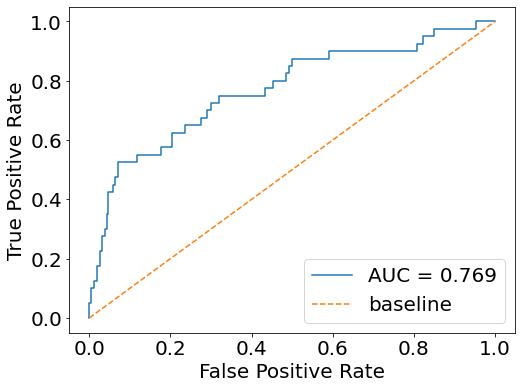

In [12]:
# ---------- area under receiver operating characteristic curve ----------

y_test_predicted_prob = lr_result.predict(X_test_impute_scale)

plt.figure(figsize=(8, 6))

fpr, tpr, _ = roc_curve(y_test, y_test_predicted_prob, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='AUC = ' + str(round(roc_auc, 3)))
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
plt.legend(loc='lower right', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=20)
plt.tick_params(labelsize=20)
print('')

print('Area Under Curve (AUC) :', auc(fpr, tpr))
print('')


Area Under Curve (AUC) : 0.4348524230835713



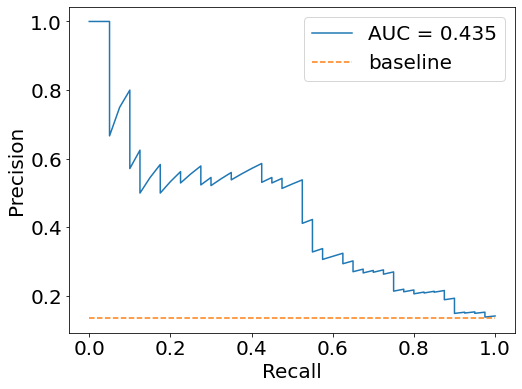

In [13]:
# ---------- area under precision recall curve ----------

y_test_predicted_prob = lr_result.predict(X_test_impute_scale)

plt.figure(figsize=(8, 6))

preci, recal, _ = precision_recall_curve(y_test, y_test_predicted_prob)
pr_auc = auc(recal, preci)

plt.plot(recal, preci, label='AUC = ' + str(round(pr_auc, 3)))
base_line = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [base_line, base_line], label='baseline', linestyle='--')
plt.legend(loc='upper right', fontsize=20)
plt.ylabel('Precision', fontsize=20)
plt.xlabel('Recall', fontsize=20)
plt.tick_params(labelsize=20)
print('')

print('Area Under Curve (AUC) :', auc(recal, preci))
print('')

### <span style='color:green'>Final performance of logistic regression with regularisation:</span>  
* <span style='color:green'>Recall=0.800 (overfit=-12.7%)</span>  
* <span style='color:green'>Precision=0.212 (overfit=-6.09%) (Expected to be low as recall is more important than precision)</span>  
* <span style='color:green'>AUROC=0.769</span>  
* <span style='color:green'>AUPRC=0.435</span>  

3 Jan 2022